In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from google.colab import  drive
import pandas as pd, matplotlib.pyplot as plt,numpy as np,tensorflow as tf
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = r'/content/drive/MyDrive/Deep learning A-Z CNN/training_set'
test_path = r'/content/drive/MyDrive/Deep learning A-Z CNN/test_set'
target_size = (150, 150)
input_shape=(150, 150, 3)
batch_size = 32

# 'Home-grown' model

In [ ]:
classifier = Sequential()
classifier.add(Convolution2D(32, 3, 3, input_shape=input_shape , activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Convolution2D(64, 3, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))

classifier.add(Flatten()) 

classifier.add(Dense(units = 128, activation ='relu'))
classifier.add(Dense(units = 1 , activation ='sigmoid'))

classifier.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               1

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_path,
                              target_size = target_size, 
                              batch_size = batch_size,
                              class_mode = 'binary')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = target_size,
                                            batch_size = batch_size,
                                            class_mode = 'binary')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)


r = classifier.fit(training_set,
              steps_per_epoch = int(np.ceil(8000/25)),#8000, # number of instances in training set 8000
              epochs=25, #so that we don't have to wait for too long to get our results
              validation_data = test_set,
              validation_steps = int(np.ceil(2000/25))#2000, # number of instances in test set 2000
              ,workers = 3
              ,callbacks=[callback]
              ) 

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/25
320/320 [==============================] - 658s 2s/step - loss: 0.6485 - accuracy: 0.6155 - val_loss: 0.5843 - val_accuracy: 0.6950
Epoch 2/25
320/320 [==============================] - 121s 375ms/step - loss: 0.5966 - accuracy: 0.6807 - val_loss: 0.6427 - val_accuracy: 0.6494
Epoch 3/25
320/320 [==============================] - 107s 333ms/step - loss: 0.5541 - accuracy: 0.7125 - val_loss: 0.5361 - val_accuracy: 0.7370
Epoch 4/25
320/320 [==============================] - 111s 345ms/step - loss: 0.5316 - accuracy: 0.7351 - val_loss: 0.5311 - val_accuracy: 0.7370
Epoch 5/25
320/320 [==============================] - 109s 337ms/step - loss: 0.5083 - accuracy: 0.7503 - val_loss: 0.4973 - val_accuracy: 0.7575
Epoch 6/25
320/320 [==============================] - 107s 331ms/step - loss: 0.4926 - accuracy: 0.7580 - val_loss: 0.5143 - val_accuracy: 0.7488
Epoch 7/25
320/320 [=======================

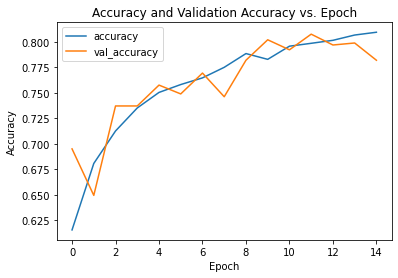

In [ ]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title("Accuracy and Validation Accuracy vs. Epoch")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Transfer learning with data augmentation

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3 as PretrainedModel
from tensorflow.keras.models import Model
pre_trained_model = PretrainedModel(input_shape = input_shape
                                ,weights = r'/content/drive/MyDrive/Deep learning A-Z CNN/inception_v3_weights.h5' #weights initialised from the h5 file
                                ,include_top = False) #instead of the full network, we just get back all the layers up to the final convolution
                                #no flatten, none of the final Dense layers
pre_trained_model.trainable = False #when we call model.fit() these weights will not be changed by gradient descent

# K = 2 #number of classes
x = Flatten()(pre_trained_model.output)
x = Dense(1, activation='sigmoid')(x) #sigmoid because it is binary classification problem 


model = Model(inputs=pre_trained_model.input, outputs=x) #creation of model object
model.summary()

#creation of ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)


#creation of generators
training_set = train_datagen.flow_from_directory(train_path,
                              target_size = target_size, 
                              batch_size = batch_size,
                              class_mode = 'binary')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = target_size,
                                            batch_size = batch_size,
                                            class_mode = 'binary')


model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

r = model.fit(training_set,
              steps_per_epoch = int(np.ceil(8000/25)), # number of instances in training set 8000
              epochs=25, #so that we don't have to wait for too long to get our results
              validation_data = test_set,
              validation_steps = int(np.ceil(8000/25)), # number of instances in test set 2000
              workers = 3
              ,callbacks=[callback]
              ) 


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_96[0][0]']              
 ormalization)                                                                                    
                                                                                            

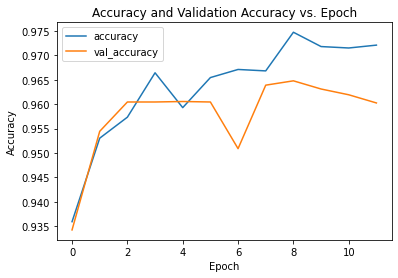

In [ ]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title("Accuracy and Validation Accuracy vs. Epoch")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()